# Understanding the `ice-keels.nc` file

This file contain a set of 2D "Hovmöller" $(t, z)$ arrays for $N_*^2$ and $\Phi$.

In [1]:
from numpy import mean
from netCDF4 import Dataset
from plot_tz import *

ncID = Dataset('ice-keels.nc', mode='r')
print(ncID)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Mixing under ice keels
    dimensions(sizes): 
    variables(dimensions): 
    groups: F05H05, F10H05, F15H05, F20H05, F05H09, F10H09, F15H09, F20H09, F05H12, F10H12, F15H12, F20H12, F05H20, F10H20, F15H20, F20H20


So, the data for each simulation is in a group. Let's see what's in the `F20H20` group.

In [2]:
print(ncID['F20H20'])

<class 'netCDF4._netCDF4.Group'>
group /F20H20:
    dimensions(sizes): time(127), depth(640)
    variables(dimensions): float64 time(time), float64 z(depth), float64 LU(depth), float64 LD(depth), float64 phiU(time, depth), float64 phiD(time, depth), float64 N2U(time, depth), float64 N2D(time, depth)
    groups: 


So, we have:
* time `t` and depth `z` 1D arrays
* The lengths of the upstream and downstream domains as a function of depth, `LU` and `LD`, respectively. They are 1D array that depend on depth because at depths less than the keel draft, the domain is shorter (we don't want to count the inside of the keel in ours stats).
* The upstream and downstream mixing rates `PhiU` and `PhiD` ($\Phi_U$ and $\Phi_D$), respectively. They are 2D, Hovmöller-type arrays.
* The upstream and downstream mean stratifications `N2U` and `N2D` ($N_{*,U}^2$ and $N_{*, D}^2$), respectively. Also 2D.

Here is how to access, say, time:

In [3]:
print('Shape of time is', ncID['F20H20']['time'][:].shape)
print('')
# print(ncID['F20H20']['time'][:])

Shape of time is (127,)



# The actual $N_*^2$

So, $N_*^2$ is treated as a scalar (actually, a time series) when one computes $K$: in the article, we write
$$\boxed{N_*^2 = \frac{g}{\rho_1}\left<\frac{\partial \overline{\rho_*}}{\partial z}\right>},$$
where $\overline\cdot$ and $\left<\cdot\right>$ denote horizontal and vertical averages, respectively. Expending the integrals and the fundamental law of calculus would yield the expression
$$N_*^2 = \frac{g}{\rho_1}\frac{\Delta \rho}{z_\Omega},$$
where $\Delta\rho$ is the density difference between very bottom and very top (sorted or not, we should get the same value), and where $z_\Omega$ is the height of the sorting domain, which is the entire domain height in our case. This expression would be the same across all experiments because we do not vary any of these parameters.
However, Sam computed the integrals in the framed expression above, and they all vary by $O(1\%)$ or so, so, let's use the framed expression.

Something like this:

In [4]:
EXP = 'F15H20'
Ns2U = mean(ncID[EXP]['N2U'][:, :], 1)  # depth average
Ns2D = mean(ncID[EXP]['N2D'][:, :], 1)  # depth average

Note that the framed expression is not the same as the integral involved in the computation of $\Phi$, which excludes the keel:
$$\left<\frac{\partial \overline{\rho_*}}{\partial z}\right> \neq \frac{1}{A}\iint_\Omega\frac{\partial \rho_*}{\partial z}\,dx\,dz,$$
because expanding the latter yields
$$\frac{\int_0^{z_\Omega}L(z)\partial_z\rho_*\,dz}{\int_0^{z_\Omega}L(z)\,dz}.$$
So, that's not great: using the same integral for $\Phi$ and $N^2_*$ would have been consistent, but the keel occupies a volume, small enough that the number can't differ by much. We can live with it.

# Comparing time series upstream and downstream, integrated with depth

## `F15H20` and `F20H20`

These two have way more mixing upstream than downstream, even though downstream looks very turbulent.

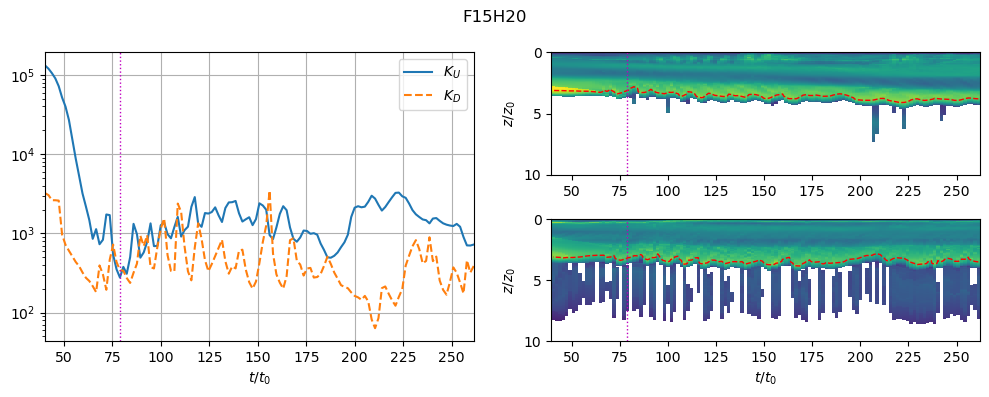

Time-averaged K_U = 6.6e+03
Time-averaged K_D = 5.7e+02


In [5]:
EXP = 'F15H20'
plot_one_exp(EXP, ncID[EXP])

I will be honest, this one baffles me. I wish we got rid of what looks like a transient at the beginning, but:

* it wouldn't solve the problem, the base levels are always higher upstream than downstream
* looking at the video, it doesn't look like anything dramatic is happening during that transient!

As for `F20H20`, it also baffles me.

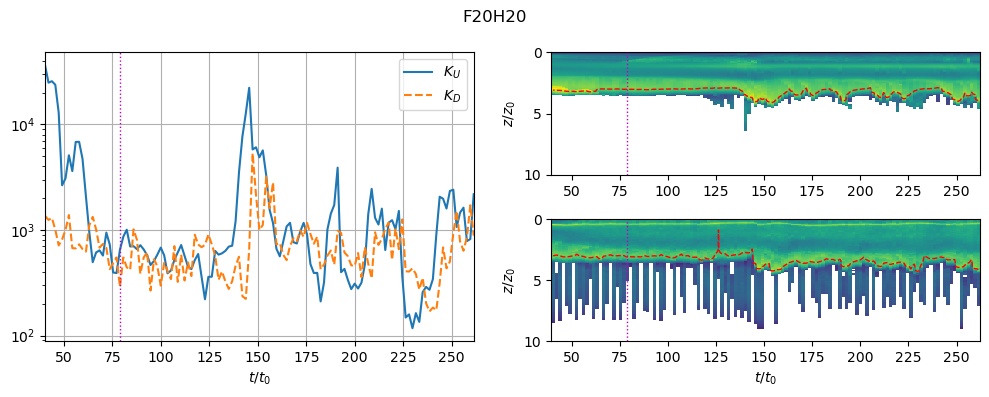

Time-averaged K_U = 2.5e+03
Time-averaged K_D = 7.6e+02


In [6]:
EXP = 'F20H20'
plot_one_exp(EXP, ncID[EXP])

For this one, the transient is also vexing. This time however, a large event seems to be happening at aroudn $t\approx 130 t_0$ (again). But if I look at the video, I don't see much around that time.

**I have no idea about what is going on in these two simulations.**

## Comparing `F15H09` and `F20H09`

I write in the article that we expect more mixing upstream for $Fr=1.5$ than for $Fr=2.0$ because when the flow is subcritical, the vortices can linger upstream and mix there. Except it's not the case for $\eta = 0.95$ and $\eta=1.2$, and I want to know why.

*Note: in this section, only compare the blue curves and the top-right panels across figures (across $Fr$). We don't care about downstream vs. upstream here.*

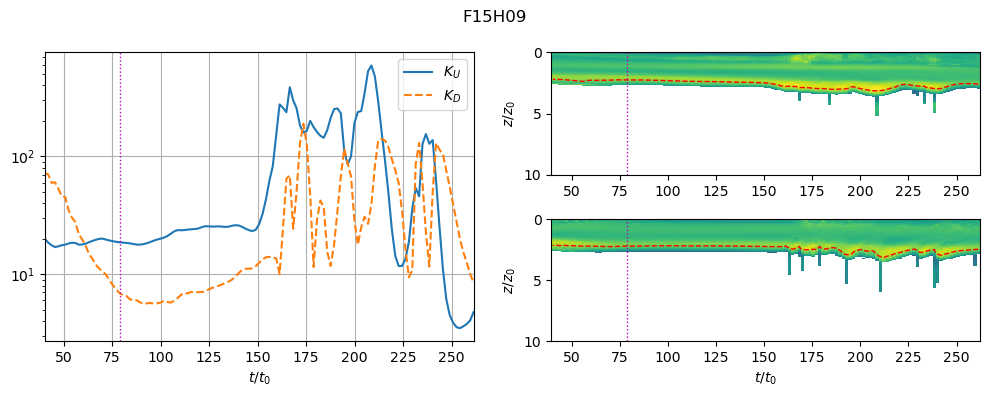

Time-averaged K_U = 8.1e+01
Time-averaged K_D = 3.4e+01


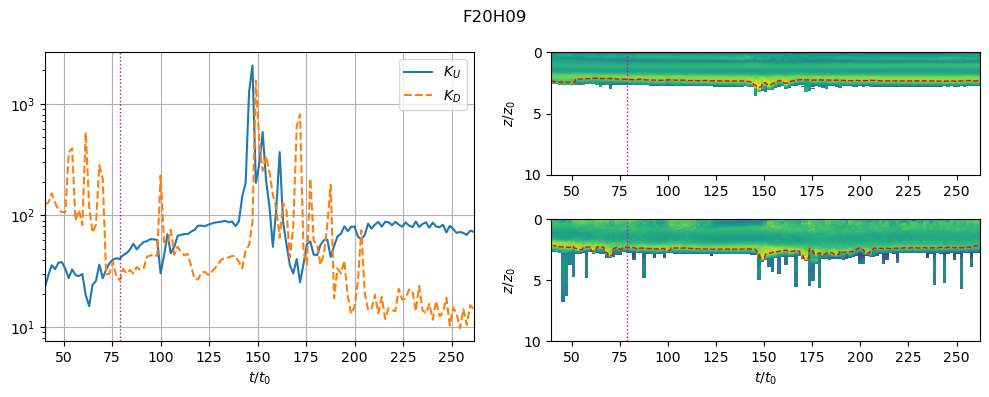

Time-averaged K_U = 1.0e+02
Time-averaged K_D = 9.3e+01


In [7]:
for EXP in ['F15H09', 'F20H09']:
    plot_one_exp(EXP, ncID[EXP])

So, the large event at $t\approx 130t_0$ in `F20H09` crushes everything. Otherwise, the base levels indeed seem higher than in `F15H09` than in `F20H09`. Freak accident.

How about $\eta = 1.2$?

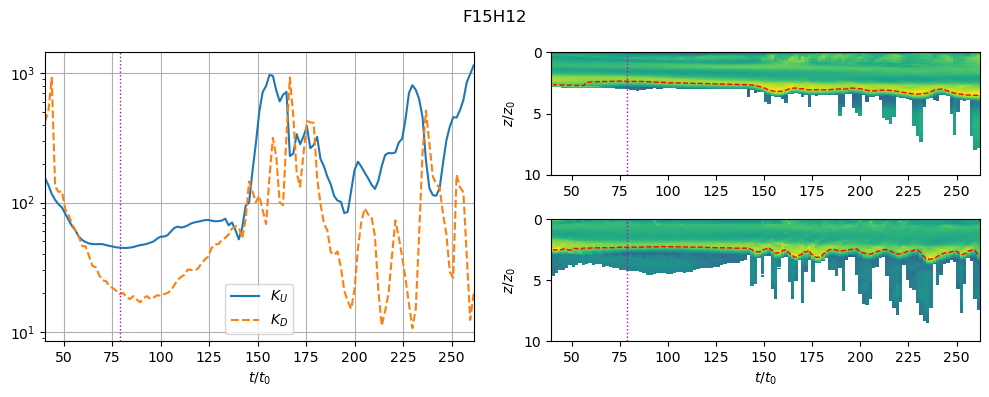

Time-averaged K_U = 2.3e+02
Time-averaged K_D = 1.0e+02


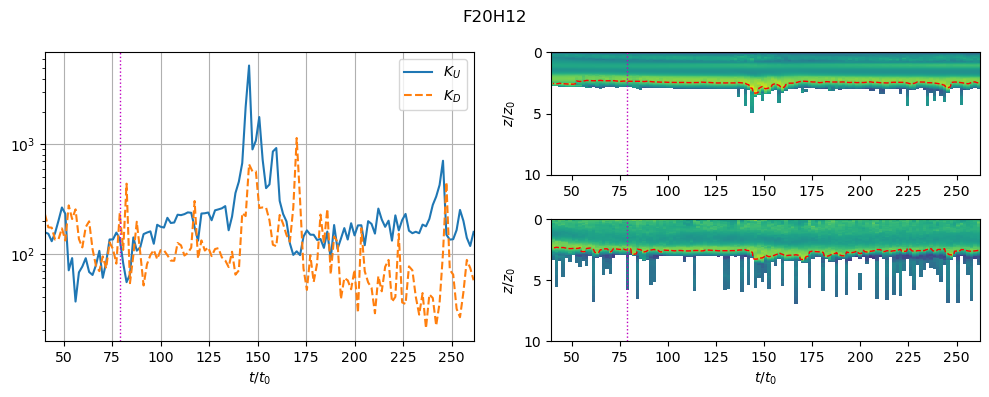

Time-averaged K_U = 2.8e+02
Time-averaged K_D = 1.4e+02


In [8]:
for EXP in ['F15H12', 'F20H12']:
    plot_one_exp(EXP, ncID[EXP])

This time, the base levels are hard to compare, but `F15H20` eventually wins over `F20H20`. There is a large event around $t\approx 130t_0$ for $Fr=2.0$ that dominates that time series.

# Plotting all experiments

I turned this cell into a raw cell to not clutter the notebook. Turn it back into a code cell to show all the experiments.

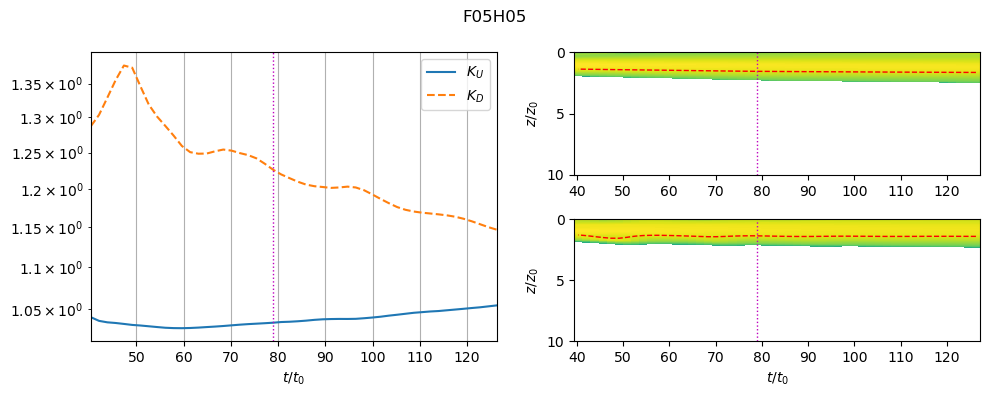

Time-averaged K_U = 1.0e+00
Time-averaged K_D = 1.2e+00


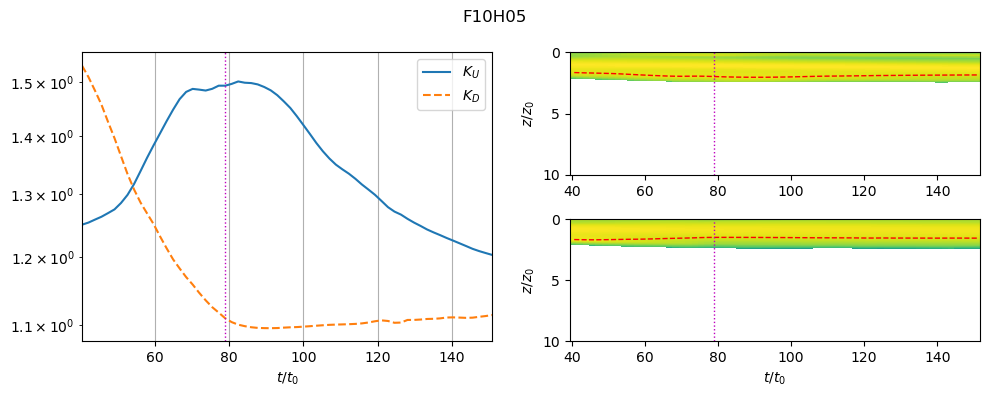

Time-averaged K_U = 1.4e+00
Time-averaged K_D = 1.2e+00


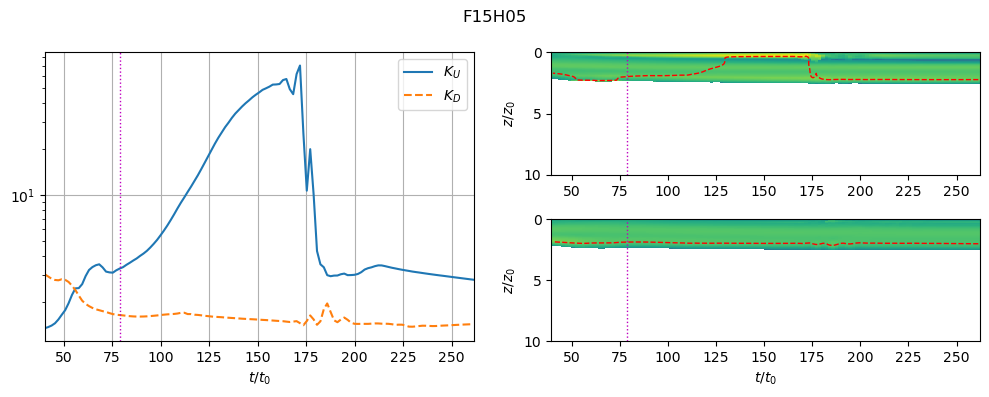

Time-averaged K_U = 1.3e+01
Time-averaged K_D = 1.6e+00


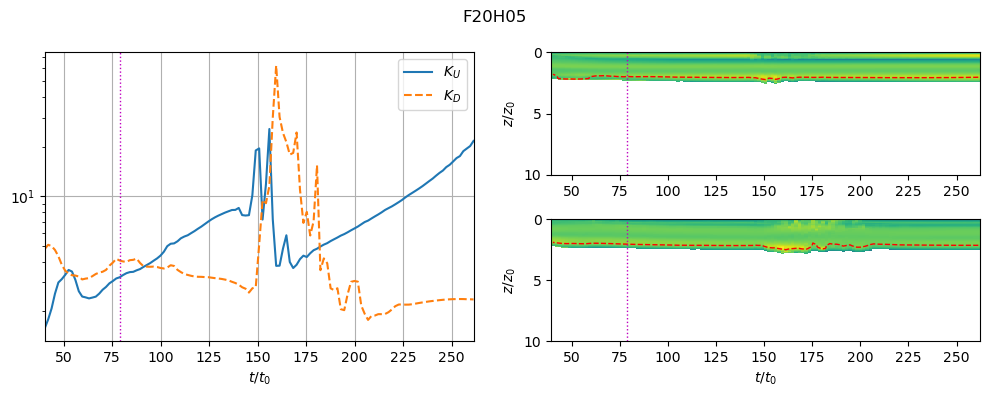

Time-averaged K_U = 7.2e+00
Time-averaged K_D = 5.1e+00


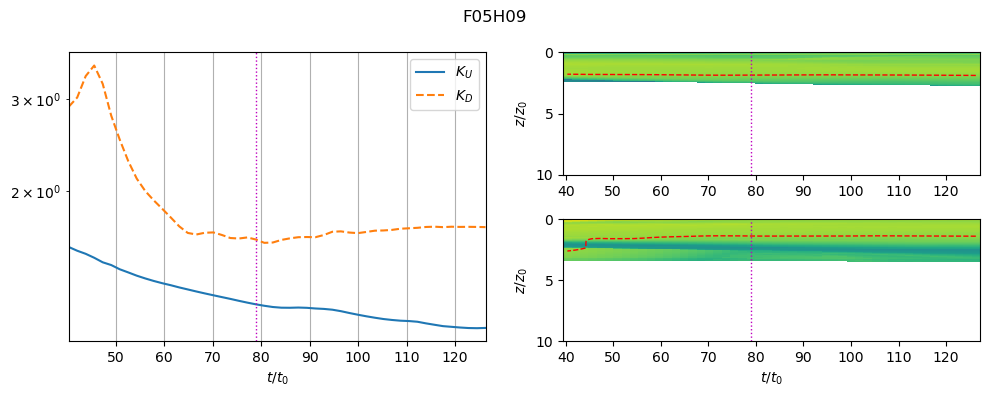

Time-averaged K_U = 1.2e+00
Time-averaged K_D = 1.9e+00


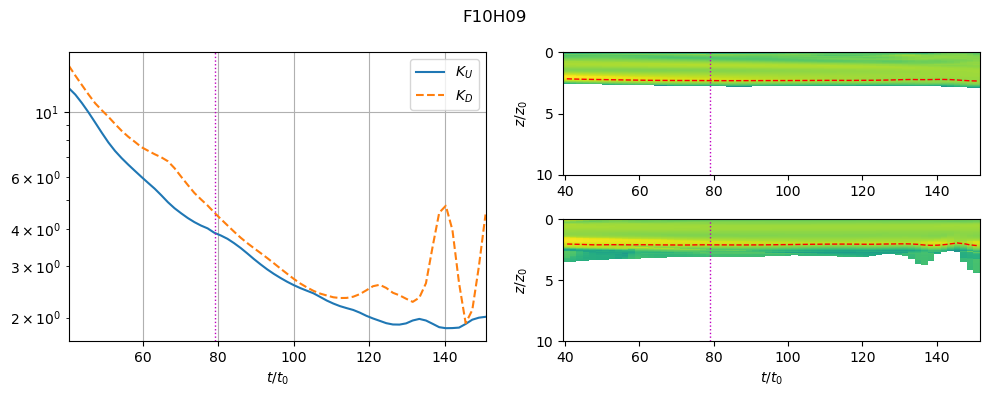

Time-averaged K_U = 3.9e+00
Time-averaged K_D = 4.8e+00


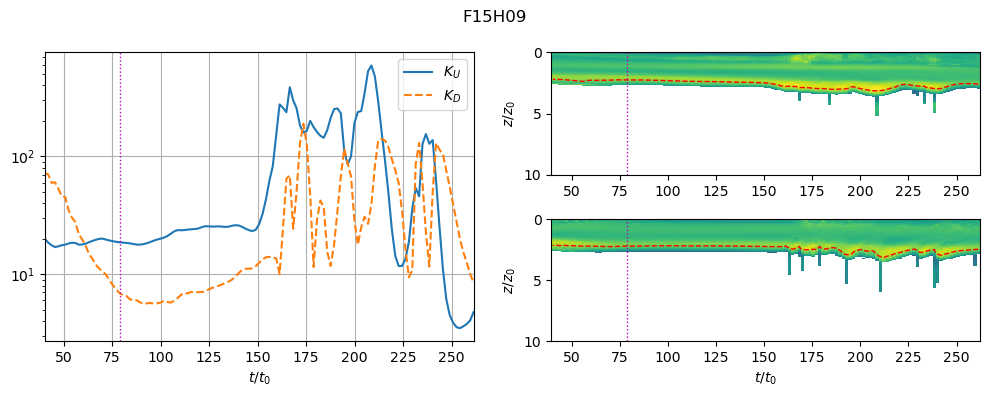

Time-averaged K_U = 8.1e+01
Time-averaged K_D = 3.4e+01


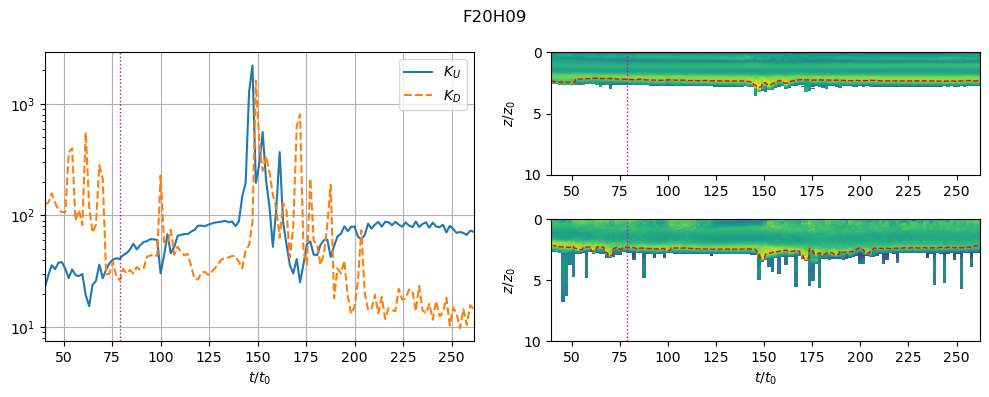

Time-averaged K_U = 1.0e+02
Time-averaged K_D = 9.3e+01


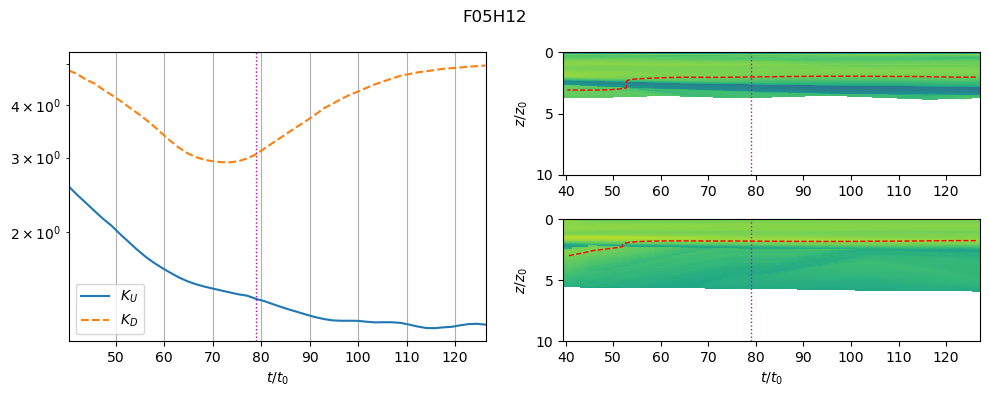

Time-averaged K_U = 1.5e+00
Time-averaged K_D = 4.0e+00


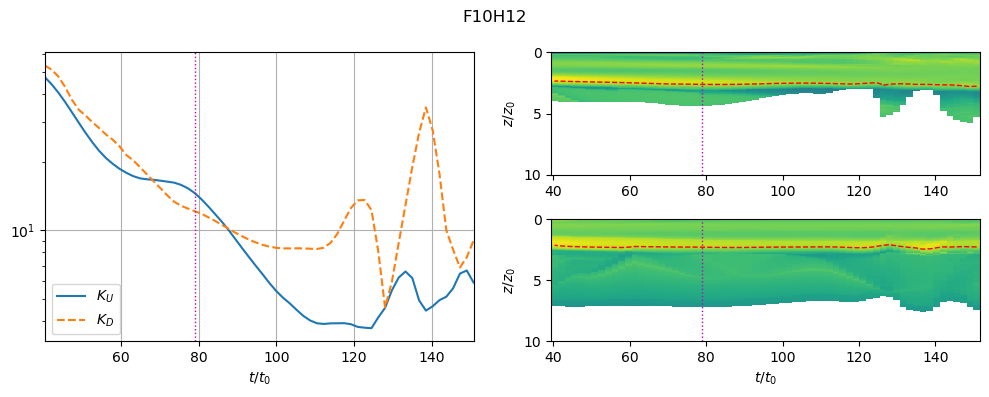

Time-averaged K_U = 1.2e+01
Time-averaged K_D = 1.7e+01


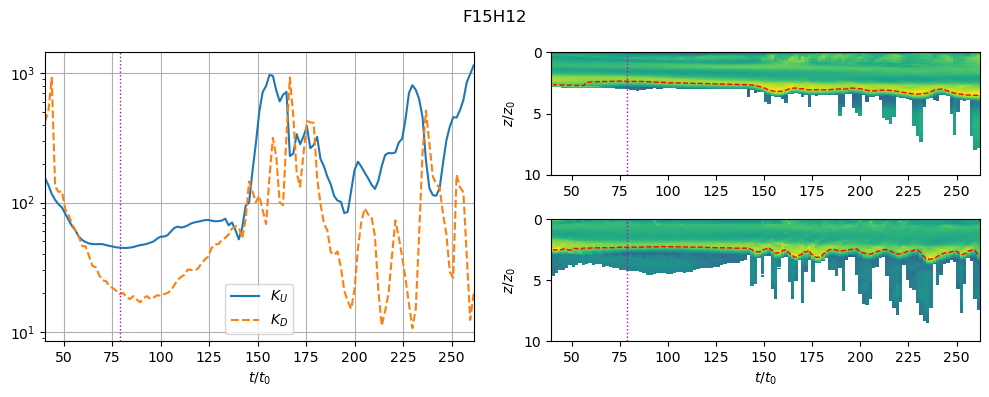

Time-averaged K_U = 2.3e+02
Time-averaged K_D = 1.0e+02


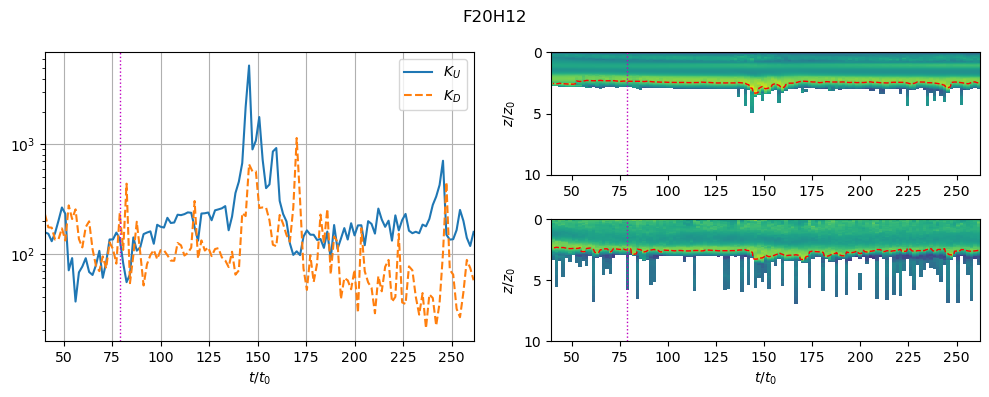

Time-averaged K_U = 2.8e+02
Time-averaged K_D = 1.4e+02


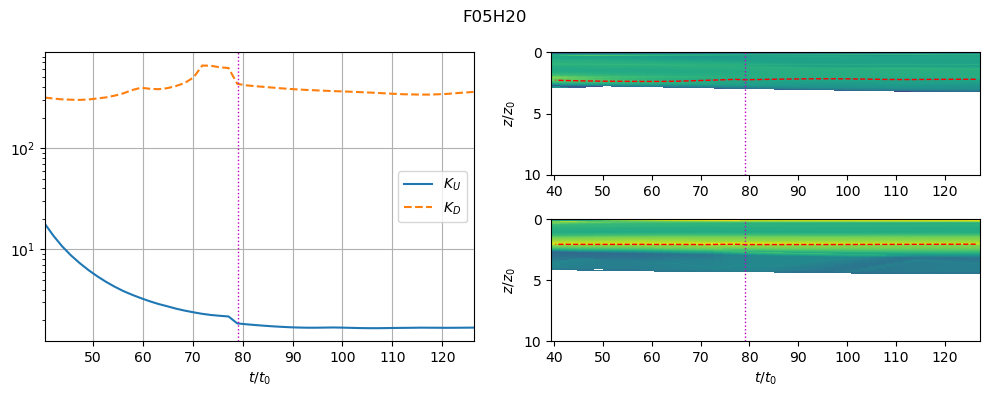

Time-averaged K_U = 3.3e+00
Time-averaged K_D = 3.8e+02


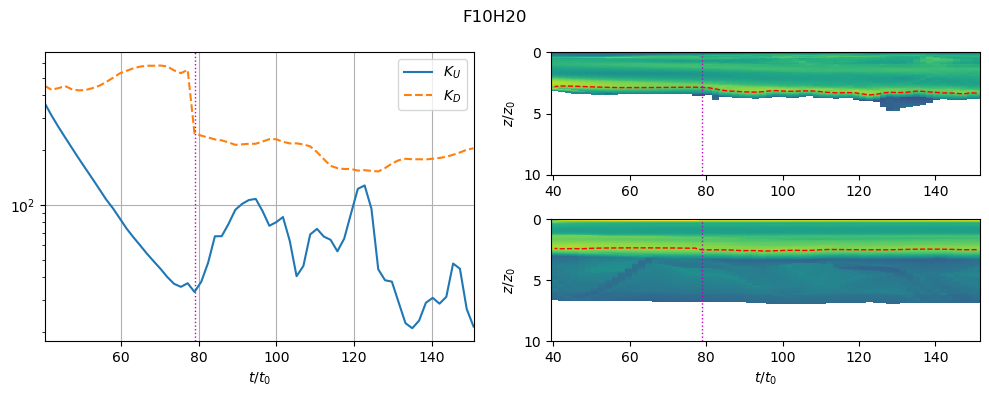

Time-averaged K_U = 8.3e+01
Time-averaged K_D = 3.0e+02


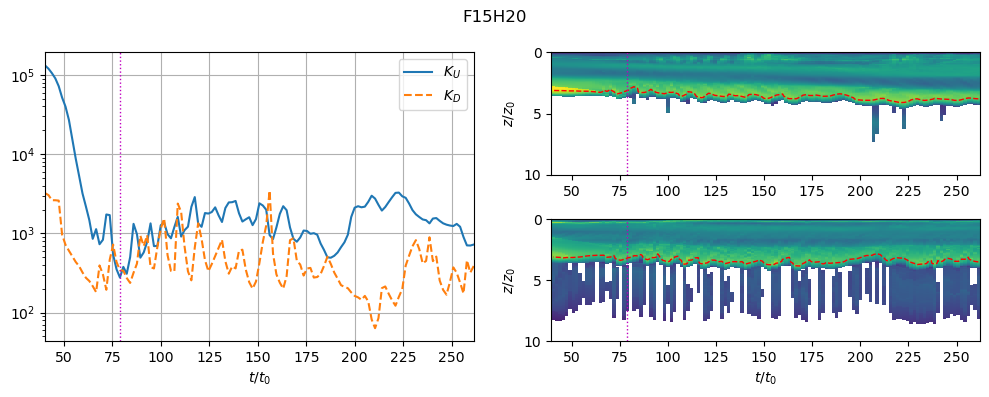

Time-averaged K_U = 6.6e+03
Time-averaged K_D = 5.7e+02


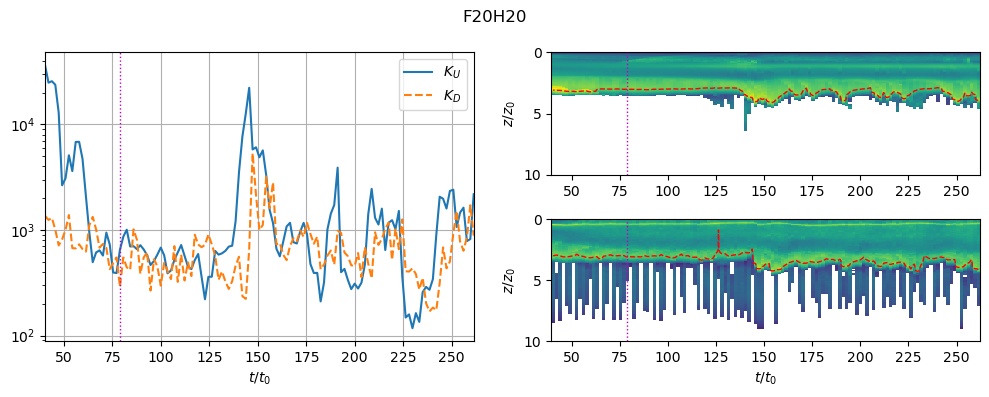

Time-averaged K_U = 2.5e+03
Time-averaged K_D = 7.6e+02


In [9]:
for EXP in ncID.groups.keys():
    plot_one_exp(EXP, ncID[EXP])